<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/Chapter9_CycleGAN(edited_lambda_cycle_1_id_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9장: CycleGAN

In [1]:
%%bash

FILE=apple2orange
rm -rf ./datasets
mkdir ./datasets

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
#wget -N $URL -O $ZIP_FILE
wget -nv -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
#unzip $ZIP_FILE -d ./datasets/
unzip $ZIP_FILE -d ./datasets/ > null
rm $ZIP_FILE

mkdir -p ./images/$FILE/

for details.

2022-06-06 11:09:52 URL:https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip [78456409/78456409] -> "./datasets/apple2orange.zip" [1]


In [2]:
import scipy
import imageio
from skimage.transform import resize
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imageio.imread(path, pilmode='RGB').astype(np.float)

In [3]:
!pip install tensorflow-addons

from __future__ import print_function, division
import scipy
from tensorflow.keras.datasets import mnist
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
class CycleGAN():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.dataset_name = 'apple2orange'
        self.data_loader = DataLoader(dataset_name=self.dataset_name, img_res=(self.img_rows, self.img_cols))

        # D(PatchGAN)의 출력 크기를 계산합니다.
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # G와 D의 첫 번째 층에 있는 필터의 개수
        self.gf = 32
        self.df = 64

        # 손실 가중치
        self.lambda_cycle = 1.0                    # 사이클-일관성 손실
        self.lambda_id = 1.0 #0.9 * self.lambda_cycle    # 동일성 손실
        # self.lambda_cycle = 10.0                    # 사이클-일관성 손실
        # self.lambda_id = 0.9 * self.lambda_cycle    # 동일성 손실

        self.optimizer = Adam(0.0002, 0.5)
        
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])
        self.d_B.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])

        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # 두 도메인의 입력 이미지
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        self.d_A.trainable = False
        self.d_B.trainable = False

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], 
                              loss_weights=[1, 1, self.lambda_cycle, self.lambda_cycle, self.lambda_id, self.lambda_id], optimizer=self.optimizer)

    @tf.function
    def train_step(self, img_A, img_B, valid):
        with tf.GradientTape() as tape: #A, tf.GradientTape() as tapeB:
            fake_B = self.g_AB(img_A)
            fake_A = self.g_BA(img_B)
            reconstr_A = self.g_BA(fake_B)
            reconstr_B = self.g_AB(fake_A)
            img_A_id = self.g_BA(img_A)
            img_B_id = self.g_AB(img_B)

            valid_A = self.d_A(fake_A)
            valid_B = self.d_B(fake_B)

            #print(img_A.shape, fake_A.shape, reconstr_A.shape, img_A_id.shape, valid_A.shape)

            mse = tf.keras.losses.MeanSquaredError()
            mae = tf.keras.losses.MeanAbsoluteError()

            A2B_g_loss = mse(valid, valid_A)
            B2A_g_loss = mse(valid, valid_B)
            A2B2A_cycle_loss = mae(img_A, reconstr_A)
            B2A2B_cycle_loss = mae(img_B, reconstr_B)
            A2A_id_loss = mae(img_A, img_A_id)
            B2B_id_loss = mae(img_B, img_B_id)

            # G_loss = [A2B_g_loss, B2A_g_loss, A2B2A_cycle_loss*self.lambda_cycle, B2A2B_cycle_loss*self.lambda_cycle, A2A_id_loss*self.lambda_id, B2B_id_loss*self.lambda_id]
            G_loss = (A2B_g_loss + B2A_g_loss) + (A2B2A_cycle_loss + B2A2B_cycle_loss) * self.lambda_cycle + (A2A_id_loss + B2B_id_loss) * self.lambda_id

        # train_loss = tf.keras.metrics.Mean()
        # train_loss(G_loss)
        # loss = train_loss.result()

        # G_gradA = tapeA.gradient(loss, self.g_AB.trainable_variables)
        # G_gradB = tapeB.gradient(loss, self.g_BA.trainable_variables)
        # self.optimizer.apply_gradients(zip(G_gradA, self.g_AB.trainable_variables))
        # self.optimizer.apply_gradients(zip(G_gradB, self.g_BA.trainable_variables))

        G_grad = tape.gradient(G_loss, self.g_AB.trainable_variables + self.g_BA.trainable_variables)
        self.optimizer.apply_gradients(zip(G_grad, self.g_AB.trainable_variables + self.g_BA.trainable_variables))
        
        return fake_A, fake_B, G_loss

    @staticmethod
    def conv2d(layer_input, filters, f_size=4, normalization=True):
        """다운샘플링하는 동안 사용되는 층"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
    
    @staticmethod
    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """업샘플링하는 동안 사용되는 층"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u        

    def build_generator(self):
        """U-Net 생성자"""
        d0 = Input(shape=self.img_shape)

        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):
        img = Input(shape=self.img_shape)

        d1 = self.conv2d(img, self.df, normalization=False)
        d2 = self.conv2d(d1, self.df * 2)
        d3 = self.conv2d(d2, self.df * 4)
        d4 = self.conv2d(d3, self.df * 8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def sample_images(self, epoch, batch_i):
        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(2, 3)
        cnt = 0
        for i in range(2):
            for j in range(3):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()

    def train(self, epochs, batch_size=1, sample_interval=50):
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)
                # fake_A, fake_B, g_loss = self.train_step(imgs_A, imgs_B, valid)

                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B])

                #if batch_i % sample_interval == 0:
                if (epoch+1) % sample_interval == 0 and batch_i == 0:
                    print("epoch : %d [D 손실: %f] [G 손실: %f]" % (epoch+1, sum(d_loss) / len(d_loss), sum(g_loss) / len(g_loss)))
                    #print("epoch : %d [D 손실: %f] [G 손실: %f]" % (epoch+1, sum(d_loss) / len(d_loss), g_loss))
                    self.sample_images(epoch, batch_i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


epoch : 10 [D 손실: 0.449791] [G 손실: 0.767408]


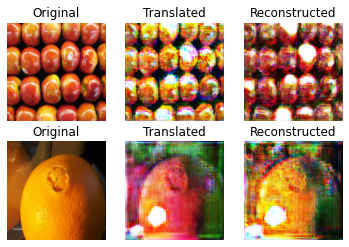

epoch : 20 [D 손실: 0.454880] [G 손실: 0.648235]


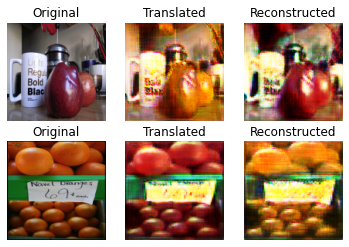

epoch : 30 [D 손실: 0.448409] [G 손실: 0.709018]


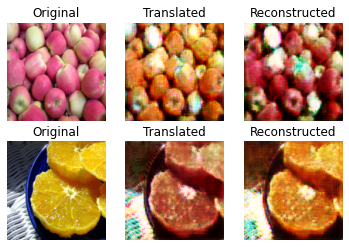

epoch : 40 [D 손실: 0.453931] [G 손실: 0.629806]


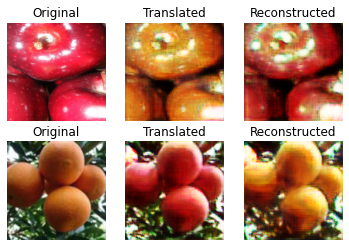

epoch : 50 [D 손실: 0.464173] [G 손실: 0.649296]


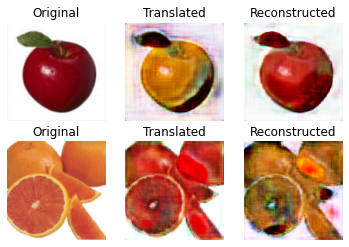

epoch : 60 [D 손실: 0.453716] [G 손실: 0.635261]


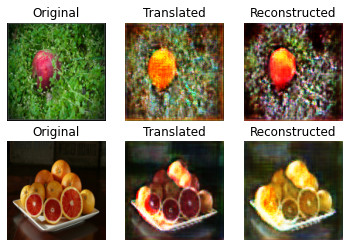

epoch : 70 [D 손실: 0.457509] [G 손실: 0.608360]


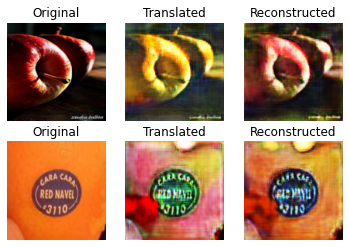

epoch : 80 [D 손실: 0.464642] [G 손실: 0.601714]


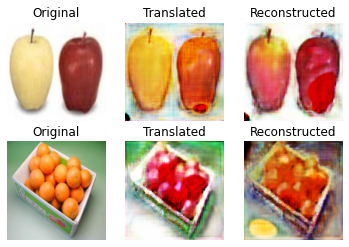

epoch : 90 [D 손실: 0.462044] [G 손실: 0.694143]


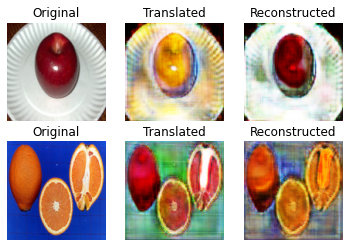

epoch : 100 [D 손실: 0.475850] [G 손실: 0.680604]


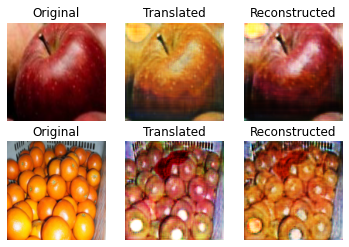

In [5]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=100, batch_size=64, sample_interval=10)

## 결과를 확인해 보겠습니다!

3가지 면을 고찰할 수 있습니다:
1. CPU나 코랩 GPU에서도 느립니다.
2. 처음 이미지는 품질이 나쁘고 알아볼 수 없습니다. 하지만 곧 괜찮은 재구성 이미지를 만듭니다.
3. 후반부 재구성의 품질은 혼재되어 있습니다. 어떤 것은 아래 그림처럼 매우 뚜렷합니다. 하지만 어떤 것은 단순히 오렌지를 사과로 채색하거나 그 반대인 것 같습니다. 논문의 저자도 이 문제를 언급했습니다. CycleGAN은 근본적으로 이미지 구조를 바꿀 수 없고 단지 스타일을 바꿉니다. 이 제약 사항을 유념하세요.

![Good examples](https://i.ibb.co/n00BW1F/163-10.png)

또한 이는 GAN 연구자와 기술자의 현실을 잘 보여줍니다. 화려한 결과 대부분은 좋은 것을 골라낸 것일 수 있습니다. 대부분 논문은 실패 케이스를 공유하지 않습니다. [BigGAN](https://arxiv.org/abs/1809.11096)은 예외입니다. BigGAN의 성능이 현재(20/11/2018) 최고입니다. 심지어 [구글 드라이브로 샘플 폴더도 공개했습니다](https://drive.google.com/drive/folders/1SRYj8Ou1JZ4e09LqeawDHcUvoeY78tPO).